# Attempt to  process a CPN dataset containing 10 different sounds

In [14]:
from src.metrics.significance import _significance, _mask_with_significance
from src.metrics.consolidated_dprimes import _load_site_formated_raste,  single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.dprime import flip_dprimes
from src.data.load import get_site_ids, set_name
from src.metrics.consolidated_metrics import metrics_to_DF, _append_means_to_array, _append_means_to_shuff_array
from src.data.region_map import region_map

import itertools as itt
import numpy as np
import pandas as pd
from configparser import ConfigParser
import pathlib as pl
from joblib import dump, load, Parallel, delayed
from src.root_path import root_path,config_path
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.fancy_plots import _raster, unit_line
from src.data.dPCA import _cpp_dPCA, format_raster

from IPython.display import display

In [15]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [28]:
#general plottin formating
plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])

In [17]:
rec_recache = False
dprime_recache = False

signif_tails = 'both'
alpha=0.05

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

expt = {'contexts': list(range(11)),
        'probes': list(range(1,11))}



## example site loaded

In [18]:
example_site = 'TNC018a'
dprime, shuffled_dprime, goodcells, var_capt = full_dPCA_dprimes(example_site, **expt, meta=meta)

print(f'dprime: {dprime.shape}')


dprime: (1, 55, 10, 30)


## run all sites
parallelized and chached

In [19]:
# run in parallel all 10sound sites, this will take a while
siteids = ['TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a', 'TNC018a']

_ = Parallel(n_jobs=4)(delayed(full_dPCA_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('full dPCA done')

full dPCA done


In [20]:
_ = Parallel(n_jobs=4)(delayed(probewise_dPCA_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('probewise dPCA done')

probewise dPCA done


In [21]:
# fails due to RAM liminations

_ = Parallel(n_jobs=4)(delayed(single_cell_dprimes)
                       (ss, **expt, meta=meta)
                        for ss in siteids)

print('signle cell done')

signle cell done


In [22]:
def load_all_raw_data(id, fulldpca=True):

    # def analysis_steps_plot(id, probe):
    site = id[:7]
    if len(id) == 7:
        population = True
    else:
        population = False

    # loads the raw data
    raster, goodcells = _load_site_formated_raste(site, **expt, meta=meta)
    trialR, R, _ = format_raster(raster)

    if population and fulldpca:
        _, trialZ, dpca = _cpp_dPCA(R, trialR)
        trialR = trialZ['ct'][:, 0, ...][:,None,...]
        dprime, shuff_dprime_quantiles, goodcells, dPCA = full_dPCA_dprimes(site, **expt, meta=meta)

    elif population and not fulldpca:
        r, n, c, p, t = trialR.shape
        trialZ = np.empty((r, 1, c, p, t))
        for probe_idx in range(p):
            probe_trialR = trialR[..., probe_idx, :]
            probe_R = R[..., probe_idx, :]

            # calculates dPCA considering all 4 categories
            _, probe_trialZ, _ = _cpp_dPCA(probe_R, probe_trialR)
            trialZ[:, :, :, probe_idx, :] = probe_trialZ['ct'][:, 0, ...][:,None,...]

        trialR = trialZ
        dprime, shuff_dprime_quantiles, goodcells, dPCA = probewise_dPCA_dprimes(site, **expt, meta=meta)

    else:
        dprime, shuff_dprime_quantiles, goodcells, dPCA = single_cell_dprimes(site, **expt, meta=meta)




    dprime, flipped_quantils = flip_dprimes(dprime, shuff_dprime_quantiles, flip='sum')
    significance, confidence_interval = _significance(dprime, flipped_quantils, [3], 3, alpha=alpha)

    t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                            endpoint=False) * 1000

    return trialR, dprime, flipped_quantils, significance, confidence_interval, goodcells, t



In [23]:
# todo make more general by omiting the cell and  probe id and instead passing the correct array slice
# PSTH and raster on the diagonal
def single_psth(trialR, cell_idx, trans_idx, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx, probe_idx, :].mean(axis=0), color=f'C{trans_idx}',
                     linewidth=3)
    return ax

def single_raster(trialR, cell_idx, trans_idx, probe_idx, ax):
    # plot raster only for single cells
    _ = _raster(t, trialR[:, cell_idx, trans_idx, probe_idx, :], y_offset=0, y_range=ax.get_ylim(), ax=ax,
                         scatter_kws={'color': f'C{trans_idx}', 'alpha': 0.4, 's': 10})
    return ax

# Paired PSTHs on the upper triangle
def double_psth(trialR, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx_0, probe_idx, :].mean(axis=0), color=f'C{trans_idx_0}',
                     linewidth=3)

    ax.plot(t, trialR[:, cell_idx, trans_idx_1, probe_idx, :].mean(axis=0), color=f'C{trans_idx_1}',
                     linewidth=3)
    return ax

# dprime plus CI on the lower triangle
def dprime_ci(dprime, confidence_interval, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')
    ax.plot(t, dprime[cell_idx, trans_pair_idx, probe_idx, :], color='white')
    ax.fill_between(t, confidence_interval[0, cell_idx, trans_pair_idx, probe_idx, :],
                    confidence_interval[1, cell_idx, trans_pair_idx, probe_idx, :],
                    color='white', alpha=0.5)
    return ax

# iterates over the grid
def grid_plot(id, trialR, dprime, confidence_interval, probe):

    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)

    fig = plt.figure(figsize=(8,8))

    n_ctx = trialR.shape[2] # Reps x Neurons x Contexts x Probex x TimePoints
    gs = fig.add_gridspec(n_ctx,n_ctx)

    first_up = True
    first_lo = True

    diagonals = list()
    for x, y in itt.product(range(n_ctx),range(n_ctx)):

        # creates subplots with shared x axis for the diagonal and upper triangle
        if x <= y:
            if first_up:
                upax = fig.add_subplot(gs[x,y])
                ax = upax
                first_up = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=upax)
        else:
            if first_lo:
                loax = fig.add_subplot(gs[x,y])
                ax = loax
                first_lo = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=loax)

        # plots upper triangle psth
        if x < y:
            _ = double_psth(trialR, cell_idx, x, y, probe_idx, ax)


        #plots lower triangle dprime
        elif x > y:
            _ = dprime_ci(dprime, confidence_interval, cell_idx, y, x, probe_idx, ax)

        # plots diagonal raster
        else:
            _ = single_psth(trialR, cell_idx, x, probe_idx, ax)
            diagonals.append(ax)

        # removes time tick labels
        if x != n_ctx-1:
            plt.setp(ax.get_xticklabels(), visible=False)

        # add time labels
        else:
            if y == int(n_ctx/2):
                ax.set_xlabel('time (ms)')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # removes y tick lables
        if y not in [0,n_ctx-1]:
            plt.setp(ax.get_yticklabels(), visible=False)

        # remove y labels on the first psth
        if y == 0 and x == 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        # dprime labels on left side
        if y == 0 and x == int(n_ctx/2):
            ax.set_ylabel("contextual effects discriminability (d')")

        # zscore firing rate ticks on right side
        if y == n_ctx-1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            if x == int(n_ctx/2):
                ax.set_ylabel('firing rate (z-score)')
            ax.spines['right'].set_visible(True)

    if len(id)>7:
        for n, ax in enumerate(diagonals):
            _ =single_raster(trialR, cell_idx, n, probe_idx, ax)
    else:
        for n, ax in enumerate(diagonals):
            ax.axhline(0, color='white', linestyle='--')

    return fig


## probewise dPCA example for best site and probe

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC018a_38a8c51bbfde8def275064f479df65378df73507.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.006640873038344959
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.
You chose to determine the regularization parameter

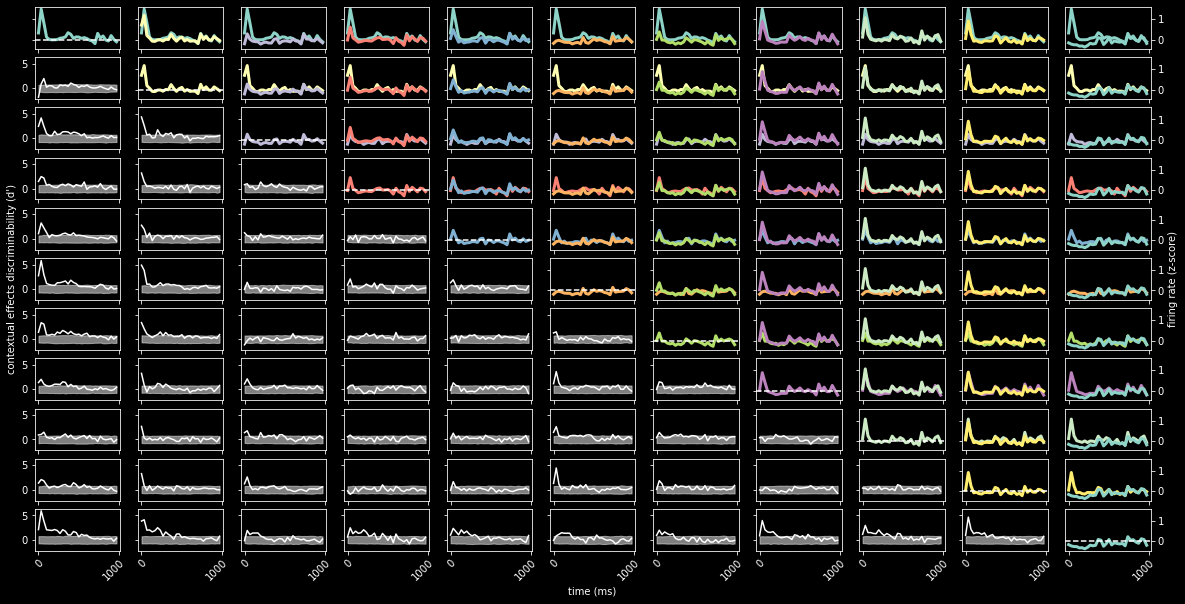

In [29]:
trialR, dprime, shuffled_dprime_quantiles, significance, confidence_interval, goodcells, t = load_all_raw_data(example_site, fulldpca=False)
fig = grid_plot(example_site, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_site}'

## full dPCA example for best site and probe

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC018a_38a8c51bbfde8def275064f479df65378df73507.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.evp


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.0017286737396774677
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


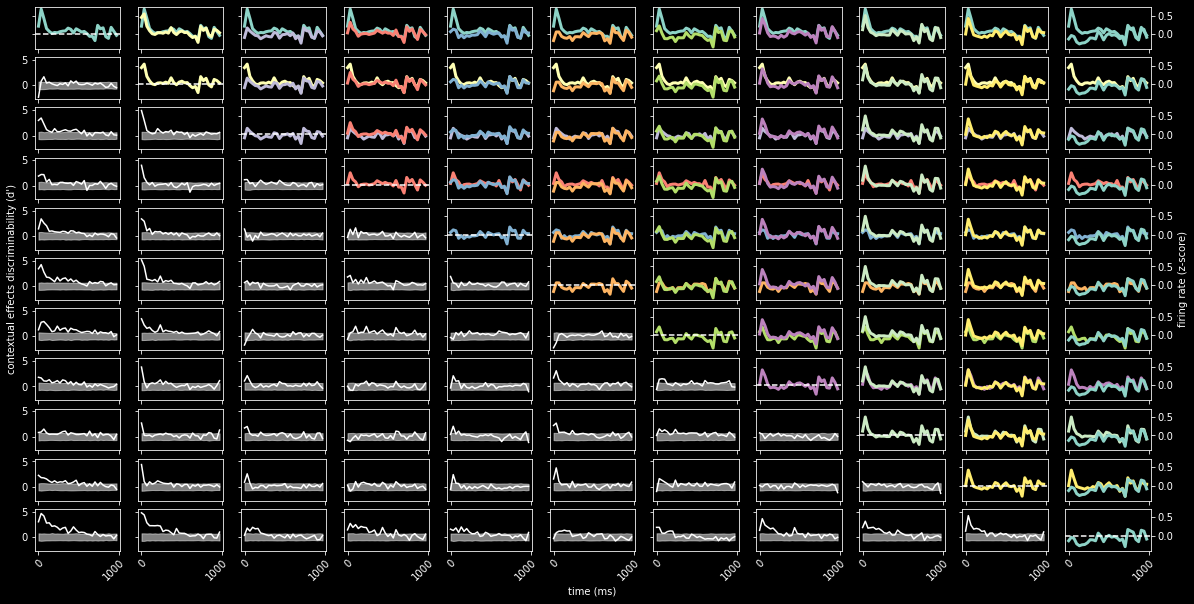

In [30]:
trialR, dprime, shuffled_dprime_quantiles, significance, confidence_interval, goodcells, t = load_all_raw_data(example_site, fulldpca=True)
fig = grid_plot(example_site, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_site}'


In [26]:
# determines the max dprime sites to plot examples
# maxes = dict()
# for site in siteids:
#     dprime,_,_,_, = full_dPCA_dprimes(site, **expt, meta=meta)
#
#
#     maxidx = np.where(np.abs(dprime) == np.max(np.abs(dprime)))
#     print(f'{site}, {maxidx}, {dprime[maxidx]}')
#     maxes[site] = maxidx
#
# determines the max dprime sites to plot examples
# maxes = dict()
# for site in siteids:
#     dprime,_,goodcells,_, = single_cell_dprimes(site, **expt, meta=meta)
#
#
#     maxidx = np.where(np.abs(dprime) == np.max(np.abs(dprime)))
#     print(f'{set(np.asarray(goodcells)[maxidx[0]])}, {maxidx}, {dprime[maxidx]}')
#     maxes[site] = maxidx

[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/TNC014a_5974a372fdafb20c8baaab7ef3c1f6ed78ba582e.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.evp


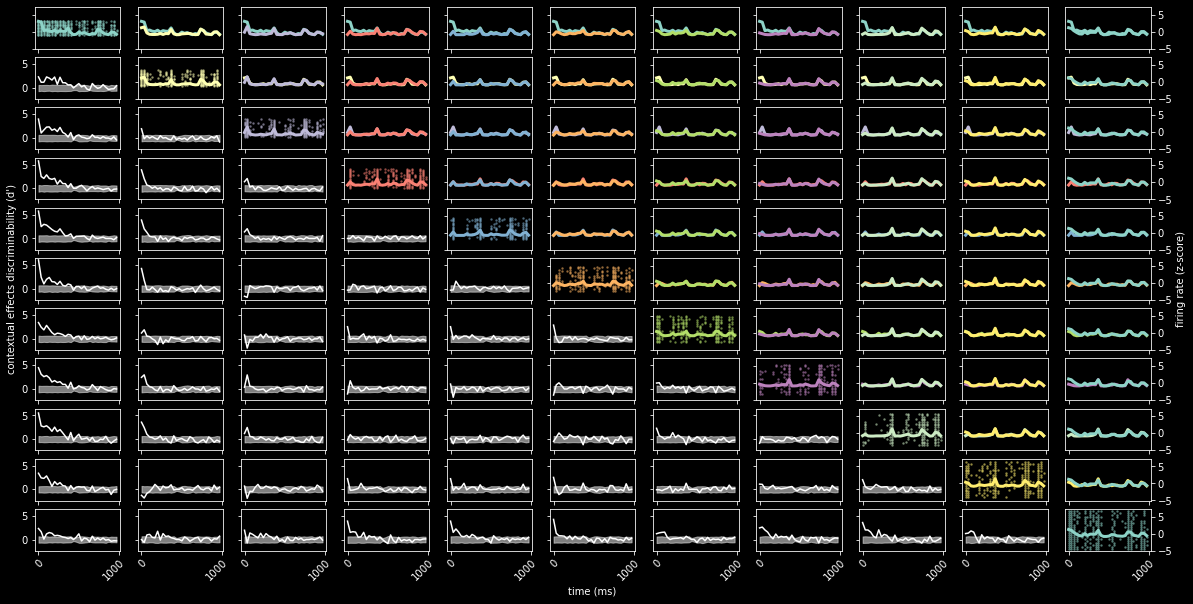

In [36]:
example_cell = 'TNC014a-22-1'
trialR, dprime, shuffled_dprime_quantiles, significance, confidence_interval, goodcells, t = load_all_raw_data(example_cell, fulldpca=True)
fig = grid_plot(example_cell, trialR, dprime, confidence_interval, 5)
fig.set_size_inches(20,10)
title =f'context_pair_grid_{example_cell}'

In [35]:
trialR.shape

(20, 44, 11, 10, 30)

# Analysiss over calculated metrics

In [48]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'210902_consolidated_summary_DF_alpha_{alpha}' / set_name(meta)
DF = load(summary_DF_file)


In [49]:
dim_reduction = 'pdPCA'

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'

ff_analylis = DF.analysis.isin(['SC', dim_reduction])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_sum': "integral (d'*ms)"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     dim_reduction: 'population'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'silence'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

filtered['trans_pair'] = comp_name_arr

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

full_long = filtered

In [50]:
def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

def nonan_proportion(arr):
    return np.sum(~np.isnan(arr))/arr.size * 100

def signif_proportion(arr):
    return np.sum(arr>0) / np.size(arr) * 100

# systematic subsampling of contexts and probes

Iterates over each contexts or probe subsampling, considering all possible combinations for each subsampling.
Counts the number definese the number of sigificant isntances. then storese in a dataframe with specific subsamples as
indices.

In [51]:
# filteres dataframe and adds required columns
filtered = pivoted.loc[pivoted.analysis=='single cell', :]
filtered['site'] = filtered.id.apply(lambda x: x[:7])

ctx_pairs = [pair.split('_') for pair in filtered.context_pair]
ctx_pairs = np.stack(ctx_pairs, axis=0)
filtered['ctx_0'] = ctx_pairs[:, 0]
filtered['ctx_1'] = ctx_pairs[:, 1]

# function to aggregate each single cell. gives the proportion of significant instances
agg_funcs = {"signif_proportion": ("integral (d'*ms)", signif_proportion)}

<ipython-input-51-f43d7c4d2b45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['site'] = filtered.id.apply(lambda x: x[:7])
<ipython-input-51-f43d7c4d2b45>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ctx_0'] = ctx_pairs[:, 0]
<ipython-input-51-f43d7c4d2b45>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [54]:
# iterates over all sizes of probe subsampling, i.e. 1, 2, 3 and 4 probes.
all_probes = filtered.probe.sort_values().unique()
prb_subsamp_signif = pd.DataFrame()

for num_probe in range(len(all_probes)):
    num_probe += 1

    n_probe_groups  = list(itt.combinations(all_probes, num_probe))
    # iterates over all possible combinations of n probes
    for pg, probe_group in enumerate(n_probe_groups):
        probe_group = [f'{p:02d}' for p in probe_group]
        probes_df = filtered.loc[filtered.probe.isin(probe_group), :].set_index('region', 'site', 'id')
        grouped  = probes_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
        grouped.loc[grouped.signif_proportion == 0] = np.nan
        grouped['n_probes'] = num_probe
        grouped['prb_group'] = '_'.join(probe_group)
        prb_subsamp_signif = prb_subsamp_signif.append(grouped.reset_index())

In [ ]:
# iterates over all sizes of context subsampling, i.e. 2, 3, 4 and 5 contexts.
all_contexts = np.unique(ctx_pairs)
ctx_subsamp_signif = pd.DataFrame()

for num_ctx in range(2, len(all_contexts)+1):
    n_ctx_groups  = list(itt.combinations(all_contexts, num_ctx))
    # iterates over all possible combinations of n probes
    for cg, ctx_group in enumerate(n_ctx_groups):
        ctx_df = filtered.loc[(filtered.ctx_0.isin(ctx_group)) &
                                 ((filtered.ctx_1.isin(ctx_group))), :].set_index('region', 'site', 'id')
        grouped  = ctx_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
        grouped.loc[grouped.signif_proportion == 0] = np.nan
        grouped['n_contexts'] = num_ctx
        grouped['ctx_group'] = '_'.join(ctx_group)
        ctx_subsamp_signif = ctx_subsamp_signif.append(grouped.reset_index())

In [ ]:
# probes
display(ctx_subsamp_signif)


## Proportion of significant instances for individual cells
only looking at cells with at least one significant instance

In [ ]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signif_proportion', data=ctx_subsamp_signif, hue='region', dodge=True, ax=ctx_ax)
_ = sns.pointplot(x='n_probes', y='signif_proportion', data=prb_subsamp_signif, hue='region', dodge=True, ax=prb_ax)

fig.suptitle('Proportion of significant instances\nfor individual cells', fontsize=20)
